# Mito Clones 

Using vireo for clonal reconstruction - mitochondrial mutations

Yuanhua @ 22/05/2024

This notebook is for the MKN45 dataset used in the [MQuad paper (Figure 4)](https://www.nature.com/articles/s41467-022-28845-0/figures/4). For earlier notebook on the Ludwig dataset, please see the notebook [vireoSNP_clones.ipynb](https://github.com/single-cell-genetics/vireo/blob/master/examples/vireoSNP_clones.ipynb).

Generally, you can use [cellSNP-lite](https://github.com/single-cell-genetics/cellsnp-lite) to genotype mitochondrial genomes and call clonal informed mtDNA variants with [MQuad](https://github.com/single-cell-genetics/MQuad).

With the filtered variants at hand, we can use the `vireoSNP.BinomMixtureVB` class to reconstruct the clonality.

In [1]:
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt

print(vireoSNP.__version__)

0.5.8


In [2]:
# np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

In [3]:
import requests
from io import BytesIO

data_path = "https://github.com/aaronkwc/MQuad_paper_reproduced_results/raw/main/mkn45/data/mquad/"

AD = mmread(BytesIO(requests.get(data_path + "passed_ad.mtx").content)).tocsc()
DP = mmread(BytesIO(requests.get(data_path + "passed_dp.mtx").content)).tocsc()

mtSNP_ids = np.genfromtxt(data_path + "passed_variant_names.txt", dtype='str')

# AD = mmread("data/passed_ad.mtx").tocsc()
# DP = mmread("data/passed_dp.mtx").tocsc()
# mtSNP_ids = np.array(['mt_variant%d' %x for x in range(AD.shape[0])])

## Identify clones

In [4]:
from vireoSNP import BinomMixtureVB

In [5]:
_model = BinomMixtureVB(n_var=AD.shape[0], n_cell=AD.shape[1], n_donor=5)
_model.fit(AD, DP, min_iter=30, n_init=50)
print(_model.ELBO_iters[-1])



-187279.56724807795


##### Check the model fitting

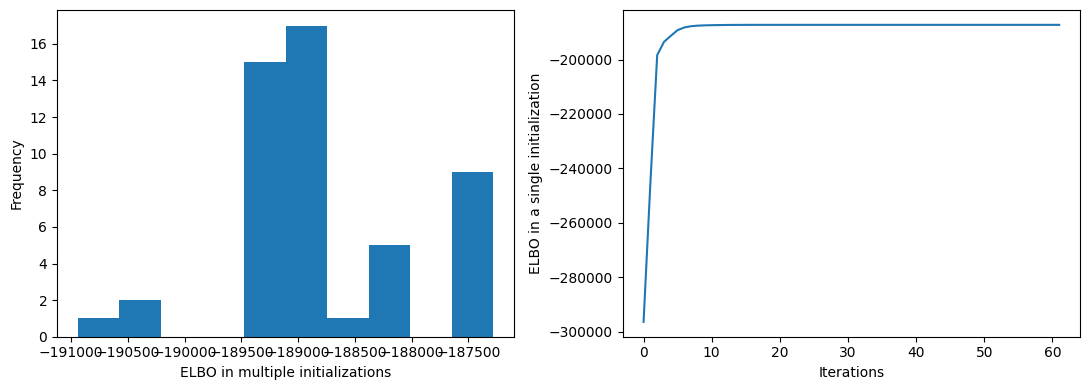

In [6]:
fig = plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.hist(_model.ELBO_inits)
plt.ylabel("Frequency")
plt.xlabel("ELBO in multiple initializations")

plt.subplot(1, 2, 2)
plt.plot(_model.ELBO_iters)
plt.xlabel("Iterations")
plt.ylabel("ELBO in a single initialization")

plt.tight_layout()
plt.show()

##### Visualize assignment probability and allele frequency

In [7]:
# In mitochondrial, allele frequency is highly informative between 0.01 to 0.1, 
# so we rescale the colour to give more spectrum for this region.
# You can design/choose your own colors from here: 
# https://matplotlib.org/stable/tutorials/colors/colormaps.html

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

raw_col = cm.get_cmap('pink_r', 200)
new_col = np.vstack((raw_col(np.linspace(0, 0.7, 10)),
                     raw_col(np.linspace(0.7, 1, 90))))
segpink = ListedColormap(new_col, name='segpink')

/tmp/ipykernel_1193464/1441482904.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  raw_col = cm.get_cmap('pink_r', 200)


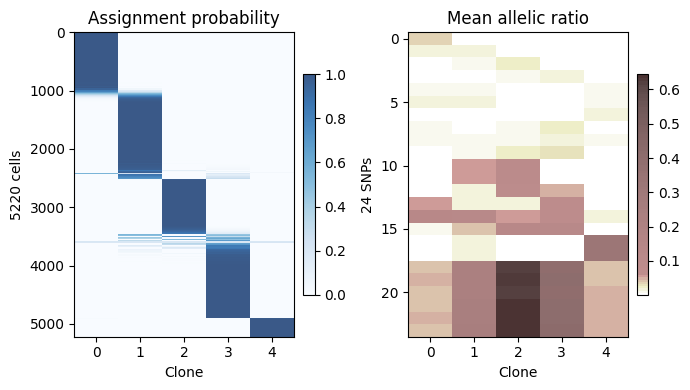

In [8]:
from vireoSNP.plot import heat_matrix

fig = plt.figure(figsize=(7, 4), dpi=100)
plt.subplot(1, 2, 1)
im = heat_matrix(_model.ID_prob, cmap="Blues", alpha=0.8,
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Assignment probability")
plt.xlabel("Clone")
plt.ylabel("%d cells" %(_model.n_cell))
plt.xticks(range(_model.n_donor))


plt.subplot(1, 2, 2)
im = heat_matrix(_model.beta_mu, cmap=segpink, alpha=0.8, 
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Clone")
plt.ylabel("%d SNPs" %(_model.n_var))
plt.xticks(range(_model.n_donor))

plt.tight_layout()
plt.show()
# plt.savefig("you_favorate_path with png or pdf")

## Diagnosis

#### Double check if global optima is found
We are using multiple initializations via `n_init` and choose the one with highest ELBO. However, this doesn't guarantee to be the global optima. To double check it, we can run the same scripts multiple time (without fixed random seed), and check if the same (best) ELBO is found.

If yes, it is likely to be the global optima, otherwise, we need increase `n_init`, e.g., 300 for more search.

In [9]:
n_init = 50
for i in range(3):
    _model = BinomMixtureVB(n_var=AD.shape[0], n_cell=AD.shape[1], n_donor=3)
    _model.fit(AD, DP, min_iter=30, n_init=n_init)
    print("rerun %d:" %i, _model.ELBO_iters[-1])

rerun 0: -204505.03278377652
rerun 1: -204505.03278377396
rerun 2: -204505.03278377466


#### Identify the suitable number of clones

It is generally difficult to identify the number of clones, which is a balance between subclone resolution and analysis reliability. More clones may be preferred, but there could be a higher risk that the subclones are not genuine but rather technical noise.

Here, we could use ELBO for different numbers of clones as an indicator for model selection. However, this is still imperfect. One empirical suggestion is to choose the `n_clones` when ELBO stops increasing dramatically, for example, in the case below, we will pick 3 clones or 5 clones.

**For visually inspecting, I would suggest making the number of clones larger (e.g., 9) and then considering merging some clones.**

In [10]:
n_init = 50
n_clone_list = np.arange(2, 10)

_ELBO_mat = []
for k in n_clone_list:
    _model = BinomMixtureVB(n_var=AD.shape[0], n_cell=AD.shape[1], n_donor=k)
    _model.fit(AD, DP, min_iter=30, n_init=n_init)
    _ELBO_mat.append(_model.ELBO_inits)

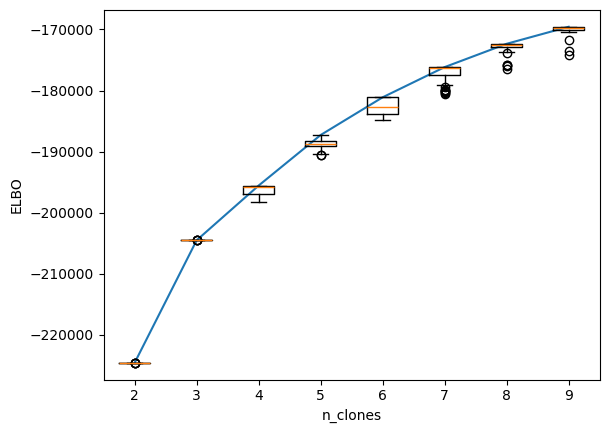

In [11]:
plt.plot(np.arange(1, len(n_clone_list)+1), np.max(_ELBO_mat, axis=1))
plt.boxplot(_ELBO_mat)
plt.xticks(np.arange(1, len(n_clone_list)+1), n_clone_list)
plt.ylabel("ELBO")
plt.xlabel("n_clones")
plt.show()

## Visualization

If you want to visualise the raw allele frequency with annotation of cells, you may consider [seaborn.clustermap](https://seaborn.pydata.org/generated/seaborn.clustermap.html). We also wrap this function here as `vireoSNP.plot.anno_heat` for quick use.

In [12]:
# label clones

cell_label = np.array(['clone%d' %x for x in np.argmax(_model.ID_prob, axis=1)])
id_uniq = np.unique(cell_label)

In [13]:
# sort variants

clone_ids = np.argmax(_model.ID_prob, axis=1)

AF_mat = AD.A/(DP.A + 0.0001)
var_idx = np.argsort(AF_mat @ (5**(max(clone_ids) - clone_ids)))[::-1]

In [14]:
var_idx

array([11,  4,  2,  1,  3,  0, 13,  7, 10,  8,  5, 15, 18, 23,  9,  6, 12,
       20, 16, 19, 21, 22, 14, 17])

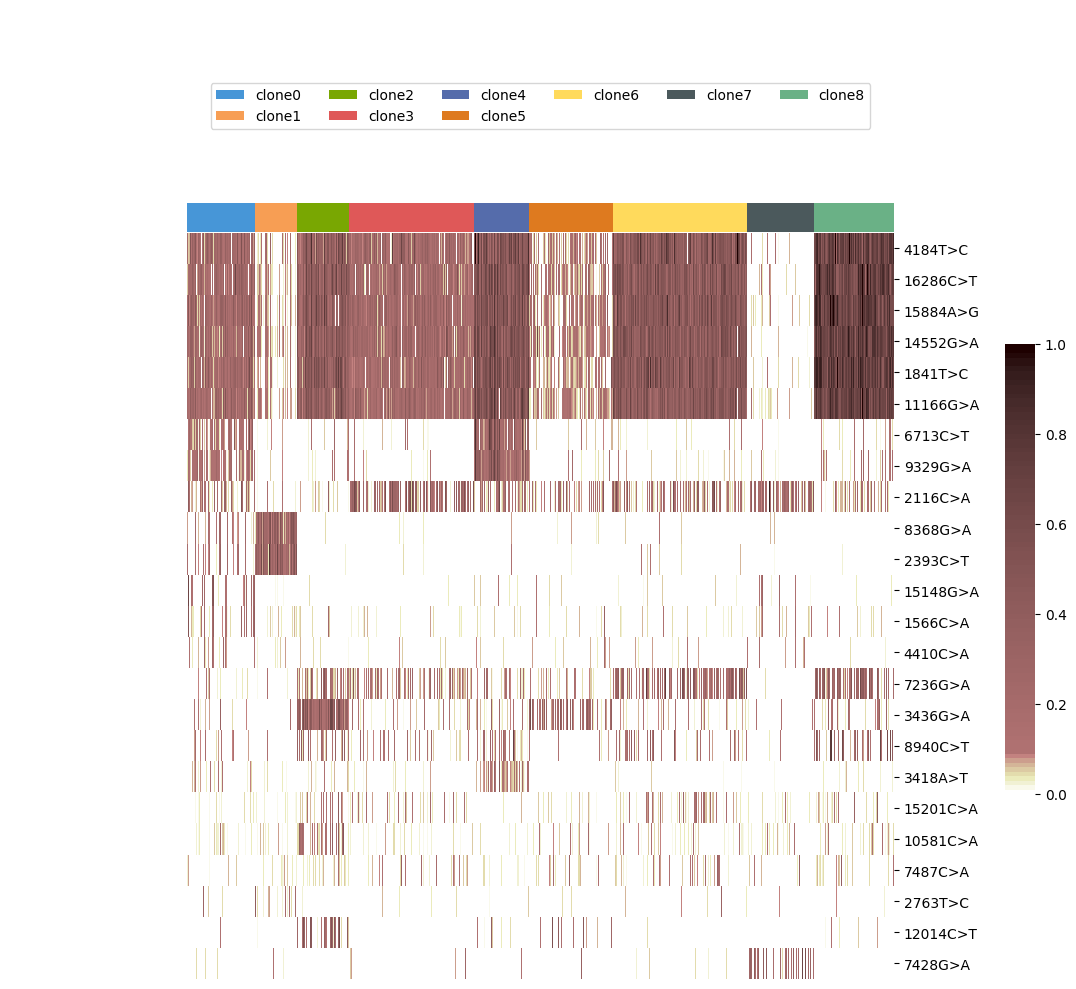

In [15]:
vireoSNP.plot.anno_heat((AD/DP)[var_idx, :], col_anno=cell_label, col_order_ids=id_uniq, 
                        cmap=segpink, yticklabels=mtSNP_ids[var_idx])